In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extraemos ejemplo

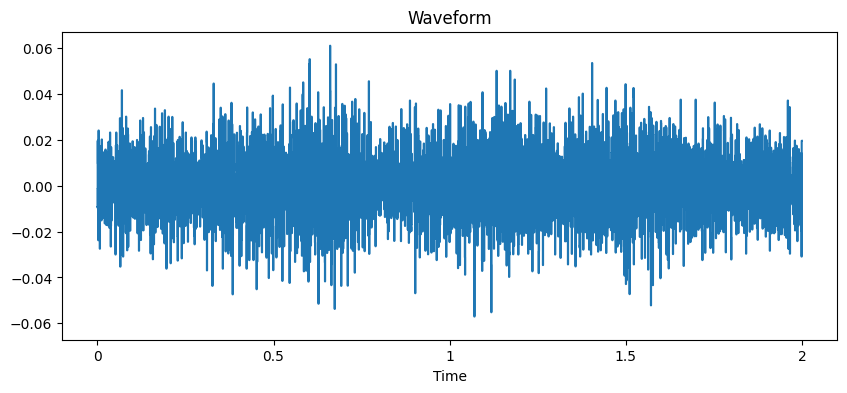

In [ ]:
file_path = '/content/drive/MyDrive/Ciclos/2024-1/Machine Learning/Proyectos/P4/project-4-whale-calls/train/train/1.wav'
y, sr = librosa.load(file_path, sr=2000)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

Audio(data=y, rate=sr)

## Extraccion de caracteristicas

In [ ]:
from concurrent.futures import ThreadPoolExecutor

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=2000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

def process_row(row, data_dir):
    file_name = f"train/train/{row['idx']}.wav"
    file_path = os.path.join(data_dir, file_name)
    if os.path.exists(file_path):
        features = extract_features(file_path)
        label = 1 if row['class'] == 'RightWhale' else 0
        return features, label
    return None

def encode(data_dir, csv_file, max_workers=4):
    df = pd.read_csv(os.path.join(data_dir, csv_file))
    data = []
    labels = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_row, row, data_dir) for _, row in df.iterrows()]
        for future in futures:
            result = future.result()
            if result:
                features, label = result
                data.append(features)
                labels.append(label)

    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [ ]:
data_dir = '/content/drive/MyDrive/Ciclos/2024-1/Machine Learning/Proyectos/P4/project-4-whale-calls/'
train_csv = 'train.csv'

#x, y = encode(data_dir, train_csv)
# Uso de la función encode

x_path = '/content/drive/MyDrive/Ciclos/2024-1/Machine Learning/Proyectos/P4/encoded_x.csv'
y_path = '/content/drive/MyDrive/Ciclos/2024-1/Machine Learning/Proyectos/P4/encoded_y.csv'

if os.path.exists(x_path) and os.path.exists(y_path):
  x = np.loadtxt(x_path, delimiter=',')
  y = np.loadtxt(y_path, delimiter=',')
else:
  x, y = encode(data_dir, train_csv, max_workers=4)
  np.savetxt(x_path, x, delimiter=',')
  np.savetxt(y_path, y, delimiter=',')

## Aplicamos normalizacion

In [ ]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

## Aplicamos PCA como reduccion de dimensioalidad

In [ ]:
pca = PCA()
pca.fit(x_scaled)

PCA()

Número óptimo de componentes principales: 11


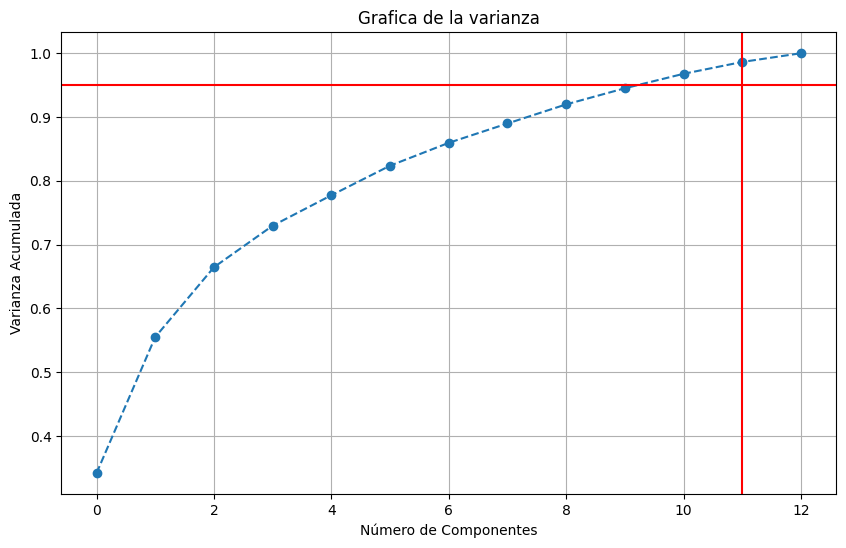

In [ ]:

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


n_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f'Número óptimo de componentes principales: {n_components}')

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=n_components, color='r', linestyle='-')
plt.title('Grafica de la varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(x_scaled)

## Realizamos split para tener train y test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)


## Clustering

In [ ]:
import seaborn as sns

def matriz_confusion(y_test, y_pred, Tipo):
  matrix = confusion_matrix(y_test, y_pred)
  f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=["NoWhale", "RightWhale"], columns=["NoWhale", "RightWhale"])

  sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
  plt.title("Confusion Matrix " + Tipo), plt.tight_layout()
  plt.xlabel("Predicted")
  plt.ylabel("Real")
  plt.show()

def test_clustering(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)

  print(f'Accuracy: {accuracy}')
  print(f'F1 Score: {f1}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  matriz_confusion(y_test, y_pred, "Test")

### K-Means++

In [ ]:
def distance(v1, v2, ax=None):
  return np.linalg.norm(v1-v2, axis=ax)


def get_init_centroids(data, k):
  n, m = data.shape
  centroids = np.empty((k, m))
  centroids[0] = data[np.random.choice(n)]
  for i in range(1, k):
    dists = np.min([distance(data, centroids[j], 1)**2 for j in range(i)], axis=0)
    probs = dists/dists.sum()
    cum_probs = np.cumsum(probs)
    r = np.random.rand()
    for j, p in enumerate(cum_probs):
      if r < p:
        centroids[i] = data[j]
        break
  return centroids


def get_new_centroids(clusters, data, k):
  new_centroids = np.array([
      np.mean(data[clusters == i], axis=0) if np.any(clusters == i) else data[np.random.choice(data.shape[0])]
      for i in range(k)
  ])
  return new_centroids


def get_cluster(data, centroids):
  dists = distance(data[:, np.newaxis], centroids, 2)
  clusters = np.argmin(dists, axis=1)
  return clusters


def avg_centroids_dist(old_centroids, new_centroids):
  avg = []
  for i in range(old_centroids.shape[0]):
      dist = distance(old_centroids[i], new_centroids[i])
      avg.append(dist)
  return np.mean(avg)


def kmeans(data, k, threshold):
  centroids = get_init_centroids(data, k)
  clusters = get_cluster(data, centroids)
  new_centroids = get_new_centroids(clusters, data, k)

  while avg_centroids_dist(centroids, new_centroids) > threshold:
     centroids = new_centroids
     clusters = get_cluster(data, centroids)
     new_centroids = get_new_centroids(clusters, data,k)

  return clusters

Accuracy: 0.7361682670324645
F1 Score: 0.7612743069921389
Precision: 0.7137315748642359
Recall: 0.8156028368794326


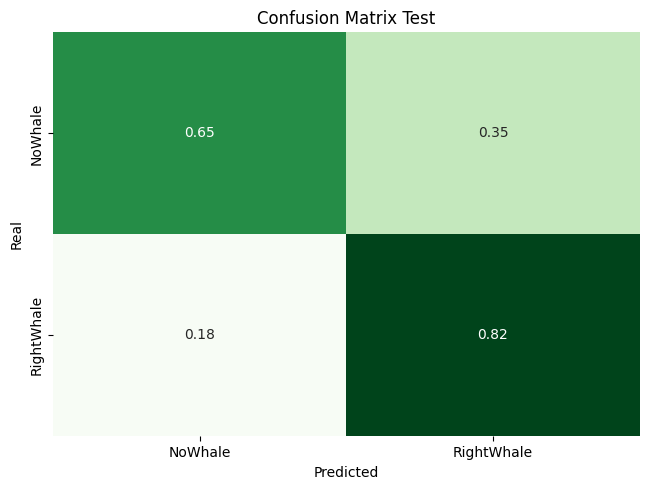

In [ ]:
y_pred_kmeans = kmeans(x_test, 2, 0.01)
test_clustering(y_test, y_pred_kmeans)

### Mean-Shift

In [ ]:
def distance(v1, v2, ax=None):
  return np.linalg.norm(v1-v2, axis=ax)


def get_means(data, centroids, radius):
  new_centroids = np.empty(centroids.shape)
  for i, centroid in enumerate(centroids):
    neighbours = []
    for point in data:
      if distance(centroid, point) <= radius:
        neighbours.append(point)
    new_centroids[i] = np.mean(neighbours, axis=0)
  var = np.mean(abs(centroids - new_centroids), axis=1)
  return new_centroids, var


def get_clusters(centroids, radius):
  n = centroids.shape[0]
  clusters = np.full(n, -1)
  cluster_id = 0
  for i in range(n):
    if clusters[i] == -1:
      clusters[i] = cluster_id
      for j in range(i + 1, n):
        if distance(centroids[i], centroids[j]) <= radius:
          clusters[j] = cluster_id
      cluster_id += 1
  return clusters


def mean_shift(data, radius, threshold):
  centroids, var = get_means(data, data, radius)
  while max(var) > threshold:
    centroids, var = get_means(data, centroids, radius)
  clusters = get_clusters(centroids, radius)
  return clusters

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4842249657064472
F1 Score: 0.0
Precision: 0.0
Recall: 0.0


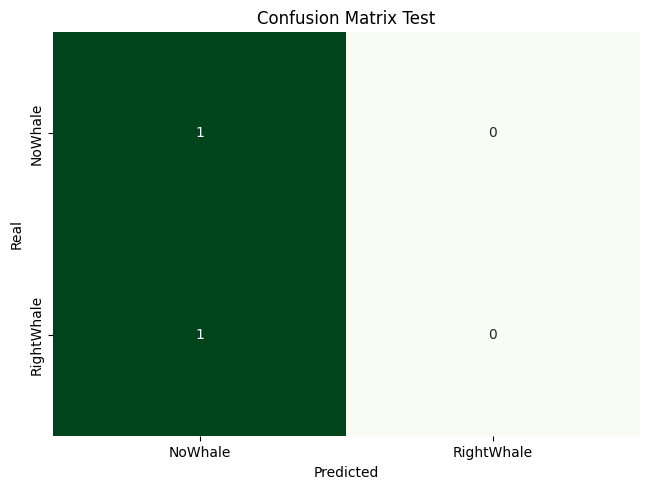

In [ ]:
y_pred_mean_shift = mean_shift(x_test, 10, 0.1) # max acc 0.4846822130772748
test_clustering(y_test, y_pred_mean_shift)

### DBSCAN

In [ ]:
import numpy as np
from scipy.spatial import KDTree

def DBSCAN(ds, radio, vecinos_min):
    tree = KDTree(ds)
    labels = np.full(len(ds), -1)
    c = 1
    for i in range(len(ds)):
        if labels[i] != -1:
            continue
        N = tree.query_ball_point(ds[i], radio)
        if len(N) < vecinos_min:
            labels[i] = 0
            continue
        labels[i] = c
        N.remove(i)
        S = set(N)
        while len(S) > 0:
            q = S.pop()
            if labels[q] == 0:
                labels[q] = c
            if labels[q] != -1:
                continue
            Nq = tree.query_ball_point(ds[q], radio)
            labels[q] = c
            if len(Nq) >= vecinos_min:
                S.update(Nq)
        c += 1
    return labels

[1]
Accuracy: 0.5157750342935528
F1 Score: 0.6805429864253393
Precision: 0.5157750342935528
Recall: 1.0


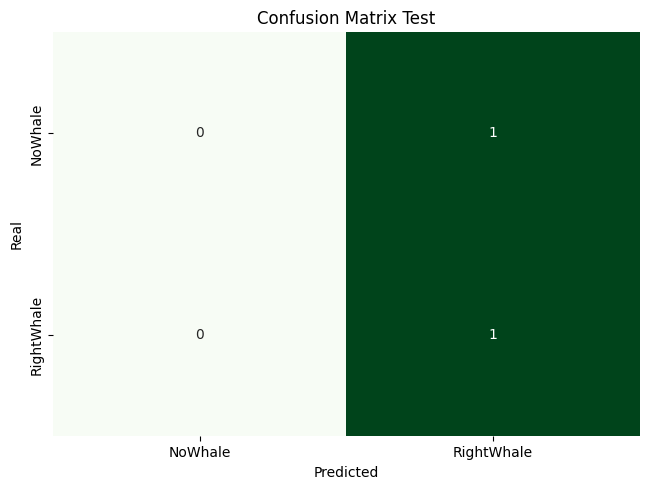

In [ ]:
y_pred_dbscan = DBSCAN(x_test, 10, 3)
test_clustering(y_test, y_pred_dbscan)

### Guardar predicciones

In [ ]:
def process_file(file_path):
    if os.path.exists(file_path):
        return extract_features(file_path)
    return None

def process_audio_files(data_dir, max_workers=4):
    data = []
    file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.wav')]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_file, file_path) for file_path in file_paths]
        for future in futures:
            result = future.result()
            if result is not None:
                data.append(result)

    data = np.array(data)
    return data

def normalize_data(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data

data_dir_test = '/content/drive/MyDrive/Ciclos/2024-1/Machine Learning/Proyectos/P4/project-4-whale-calls/test/test'
data = process_audio_files(data_dir_test, max_workers=4)
normalized_data = normalize_data(data)
pca = PCA(n_components=n_components)
x_test_pca = pca.fit_transform(normalized_data)

In [61]:
y_pred_kmeans = kmeans(normalized_data, 2, 0.01)
results_df = pd.DataFrame({'idx': range(len(y_pred_kmeans)), 'class': ["RightWhale" if x == 0 else "NoWhale" for x in y_pred_kmeans]})
results_df.to_csv('predictions_kmeans.csv', index=False)